In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import umap.umap_ as umap
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

In [2]:
# Configuration
SR = 21050 # Sample rate
DURATION = 1.0
N_FFT = 2048
N_MELS = 128
HOP_LENGTH = 512
FIXED_SHAPE = (N_MELS, int(SR * DURATION / HOP_LENGTH) + 1)

### Direct Comparison Between 2 Audio Files

In [3]:
audio_path_1 = "mswc_microset/mswc_microset/en/clips/dog/common_voice_en_3289.opus"
ipd.Audio(audio_path_1, rate=SR)

In [4]:
audio_path_2 = "mswc_microset/mswc_microset/en/clips/cat/common_voice_en_5170477.opus"
ipd.Audio(audio_path_2, rate=SR)

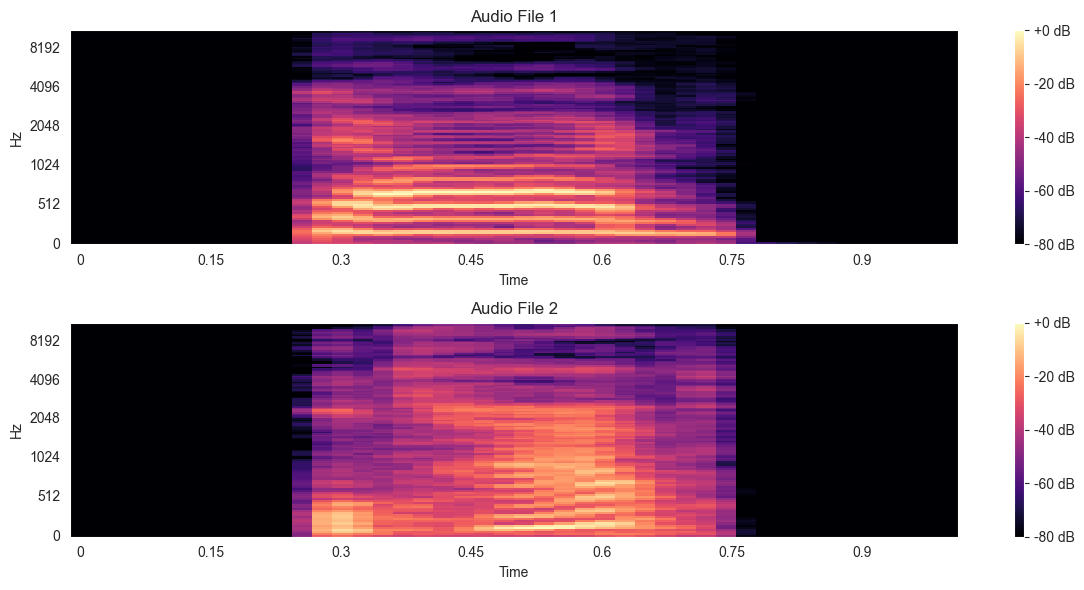

In [5]:
# Load Audio Files
y1, sr1 = librosa.load(audio_path_1)
y2, sr2 = librosa.load(audio_path_2)

# Convert to Mel Spectrograms
S1 = librosa.feature.melspectrogram(y=y1, sr=sr1, n_mels=128)
S2 = librosa.feature.melspectrogram(y=y2, sr=sr2, n_mels=128)

S_dB1 = librosa.power_to_db(S1, ref=np.max)
S_dB2 = librosa.power_to_db(S2, ref=np.max)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
librosa.display.specshow(S_dB1, sr=sr1, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Audio File 1')

plt.subplot(2, 1, 2)
librosa.display.specshow(S_dB2, sr=sr2, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Audio File 2')

plt.tight_layout()
plt.show()

### Visualisation of Mel Spectrogram

In [6]:
def audio_to_melspectrogram(audio_path):
    try:
        # Load with fixed duration (pad/trim as needed)
        y, sr = librosa.load(audio_path, sr=SR, duration=DURATION)
        if len(y) < SR * DURATION:
            y = np.pad(y, (0, max(0, int(SR * DURATION) - len(y))))

        # Generate fixed-length spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT,
                                         hop_length=HOP_LENGTH,
                                         n_mels=N_MELS)
        log_S = librosa.power_to_db(S, ref=np.max)

        # Ensure consistent shape
        if log_S.shape != FIXED_SHAPE:
            log_S = log_S[:, :FIXED_SHAPE[1]]  # Truncate or pad columns
            if log_S.shape[1] < FIXED_SHAPE[1]:
                log_S = np.pad(log_S, ((0,0), (0,FIXED_SHAPE[1]-log_S.shape[1])))

        return log_S.flatten()
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

In [7]:
wavs = list(Path("mswc_microset/mswc_microset/en/clips").rglob("*.opus"))
print(f"Found {len(wavs)} files")

keyword_dict = defaultdict(list)
for wav in wavs:
    label = wav.parts[-2]
    if len(keyword_dict[label]) < 15:
        keyword_dict[label].append(wav)

Found 96099 files


In [8]:
spectrograms = []
valid_labels = []
for label, paths in keyword_dict.items():
    for path in paths:
        spec = audio_to_melspectrogram(str(path))
        if spec is not None:
            spectrograms.append(spec)
            valid_labels.append(label)

In [9]:
spectrograms = np.stack(spectrograms)  # Uses stack instead of array for safety
print(f"Final array shape: {spectrograms.shape}")

Final array shape: (465, 5376)


In [10]:
# Standardize and project
scaler = StandardScaler()
scaled = scaler.fit_transform(spectrograms)
embedding = umap.UMAP(random_state=42).fit_transform(scaled)

C:\Users\tyree\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tyree\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [11]:
# Plot
df = pd.DataFrame({
    'x': embedding[:,0],
    'y': embedding[:,1],
    'keyword': valid_labels
})

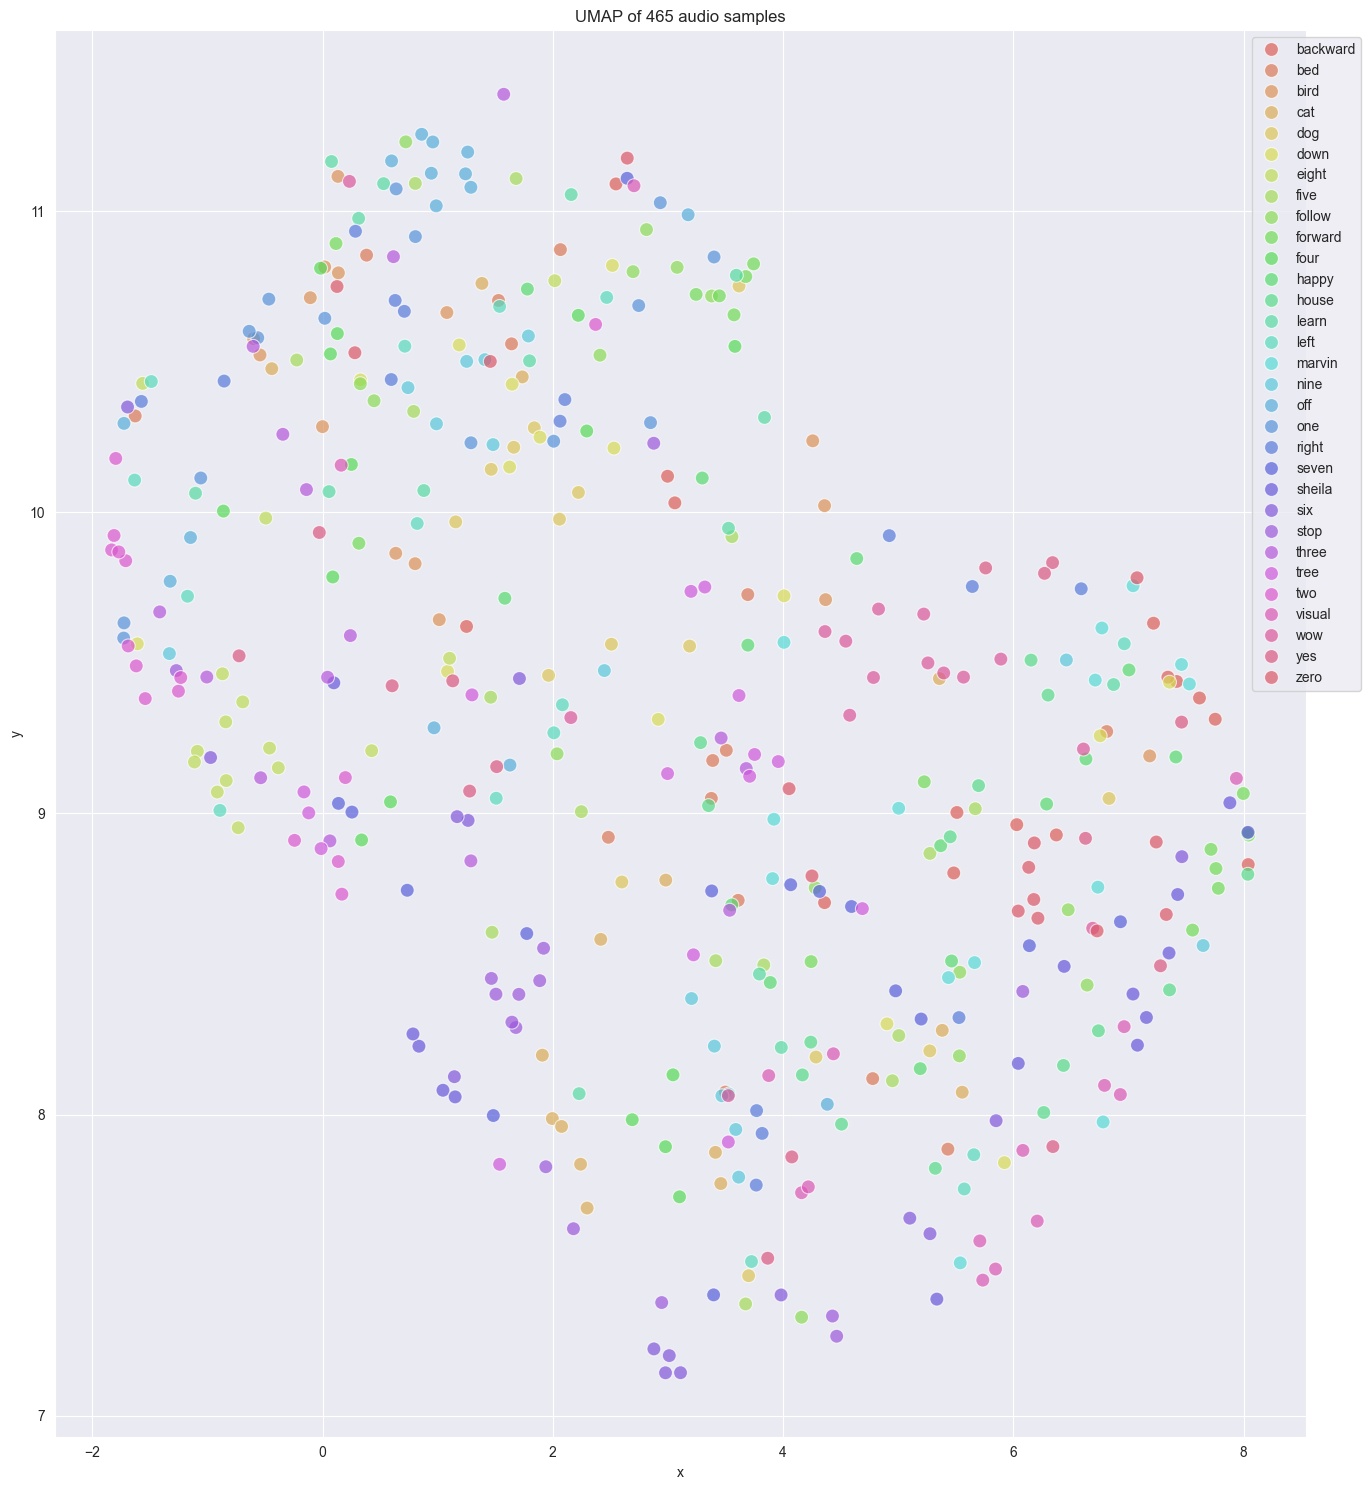

In [12]:
plt.figure(figsize=(15,15))
sns.scatterplot(
    x='x', y='y',
    hue='keyword',
    data=df,
    palette=sns.color_palette('hls', len(set(valid_labels))),
    s=100,
    alpha=0.7
)
plt.title(f"UMAP of {len(valid_labels)} audio samples")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

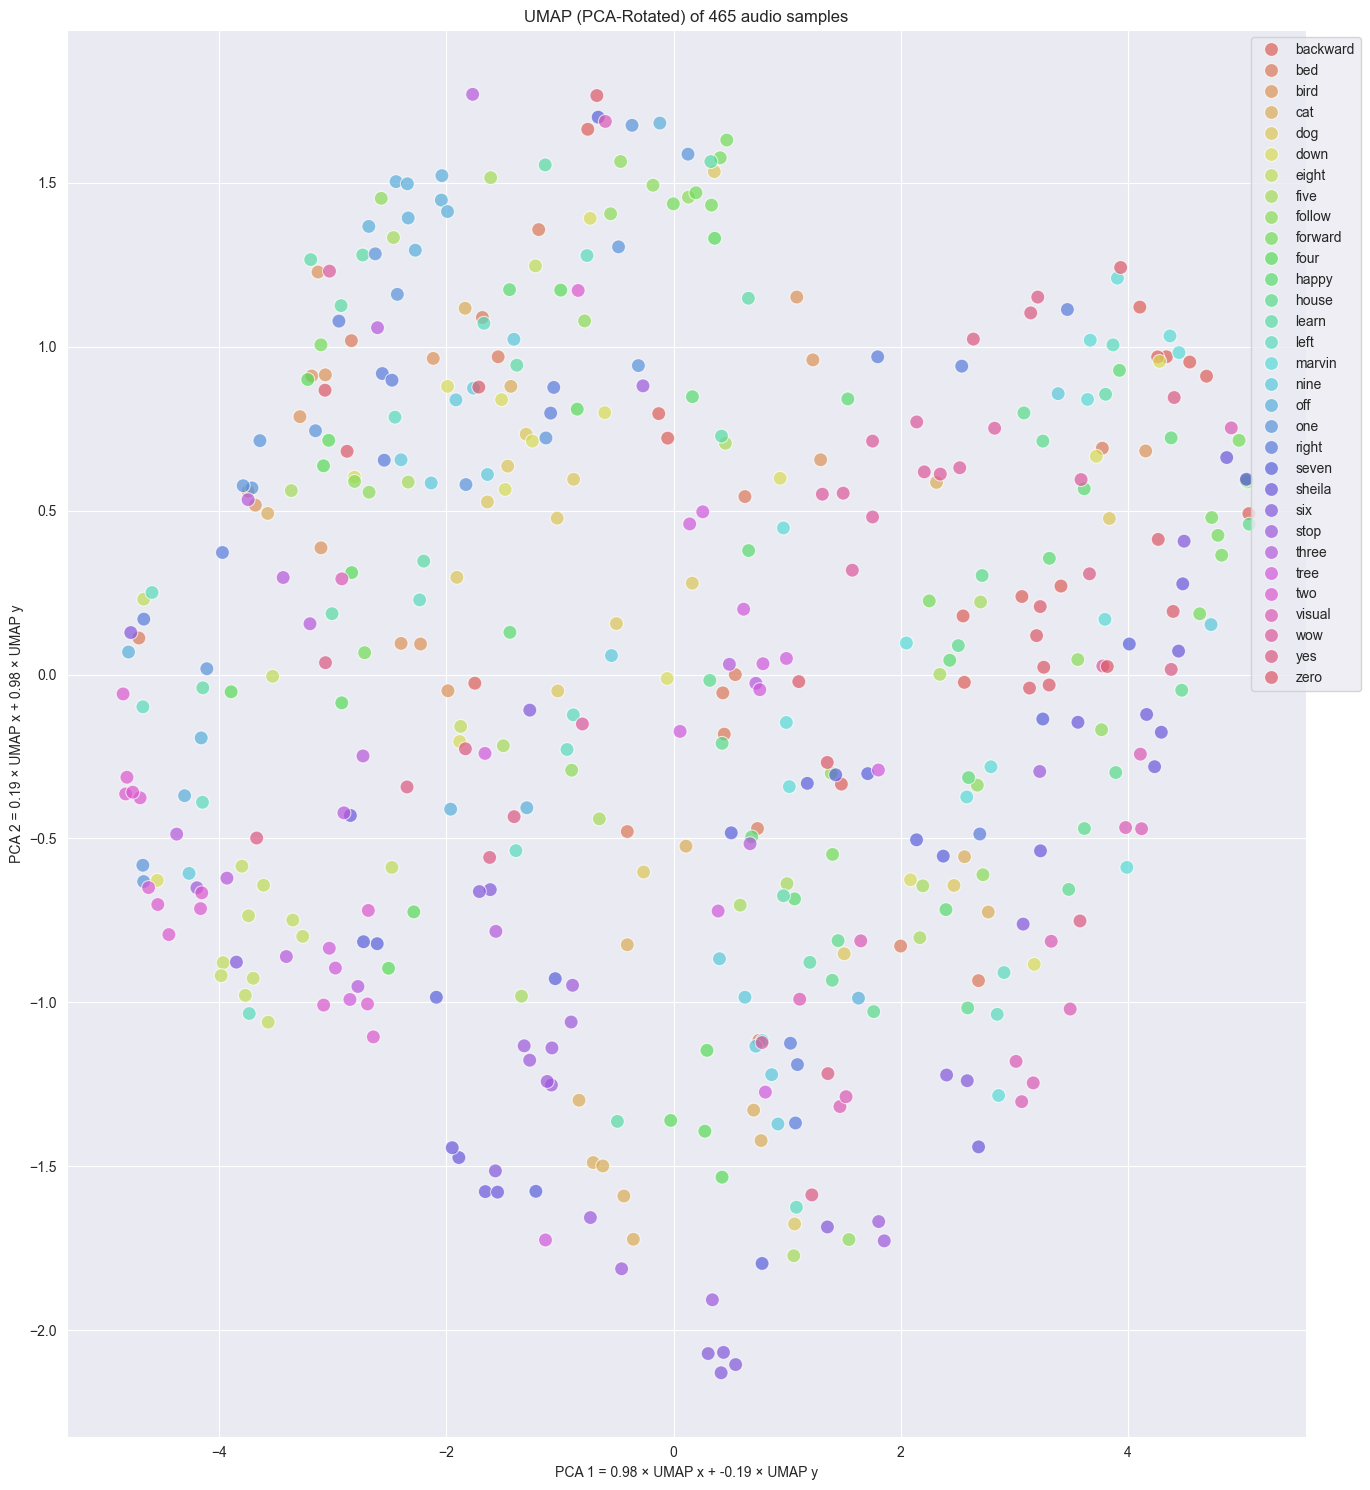

In [13]:
from sklearn.decomposition import PCA

# Apply PCA to rotate the UMAP embedding
pca = PCA(n_components=2)
rotated_embedding = pca.fit_transform(embedding)

# Get PCA component coefficients
pc1 = pca.components_[0]
pc2 = pca.components_[1]

# Format axis labels
x_label = f'PCA 1 = {pc1[0]:.2f} × UMAP x + {pc1[1]:.2f} × UMAP y'
y_label = f'PCA 2 = {pc2[0]:.2f} × UMAP x + {pc2[1]:.2f} × UMAP y'

# Create DataFrame for plotting
rotated_df = pd.DataFrame({
    'x': rotated_embedding[:, 0],
    'y': rotated_embedding[:, 1],
    'keyword': valid_labels
})

# Plot
plt.figure(figsize=(15, 15))
sns.scatterplot(
    x='x', y='y',
    hue='keyword',
    data=rotated_df,
    palette=sns.color_palette('hls', len(set(valid_labels))),
    s=100,
    alpha=0.7
)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(f"UMAP (PCA-Rotated) of {len(valid_labels)} audio samples")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


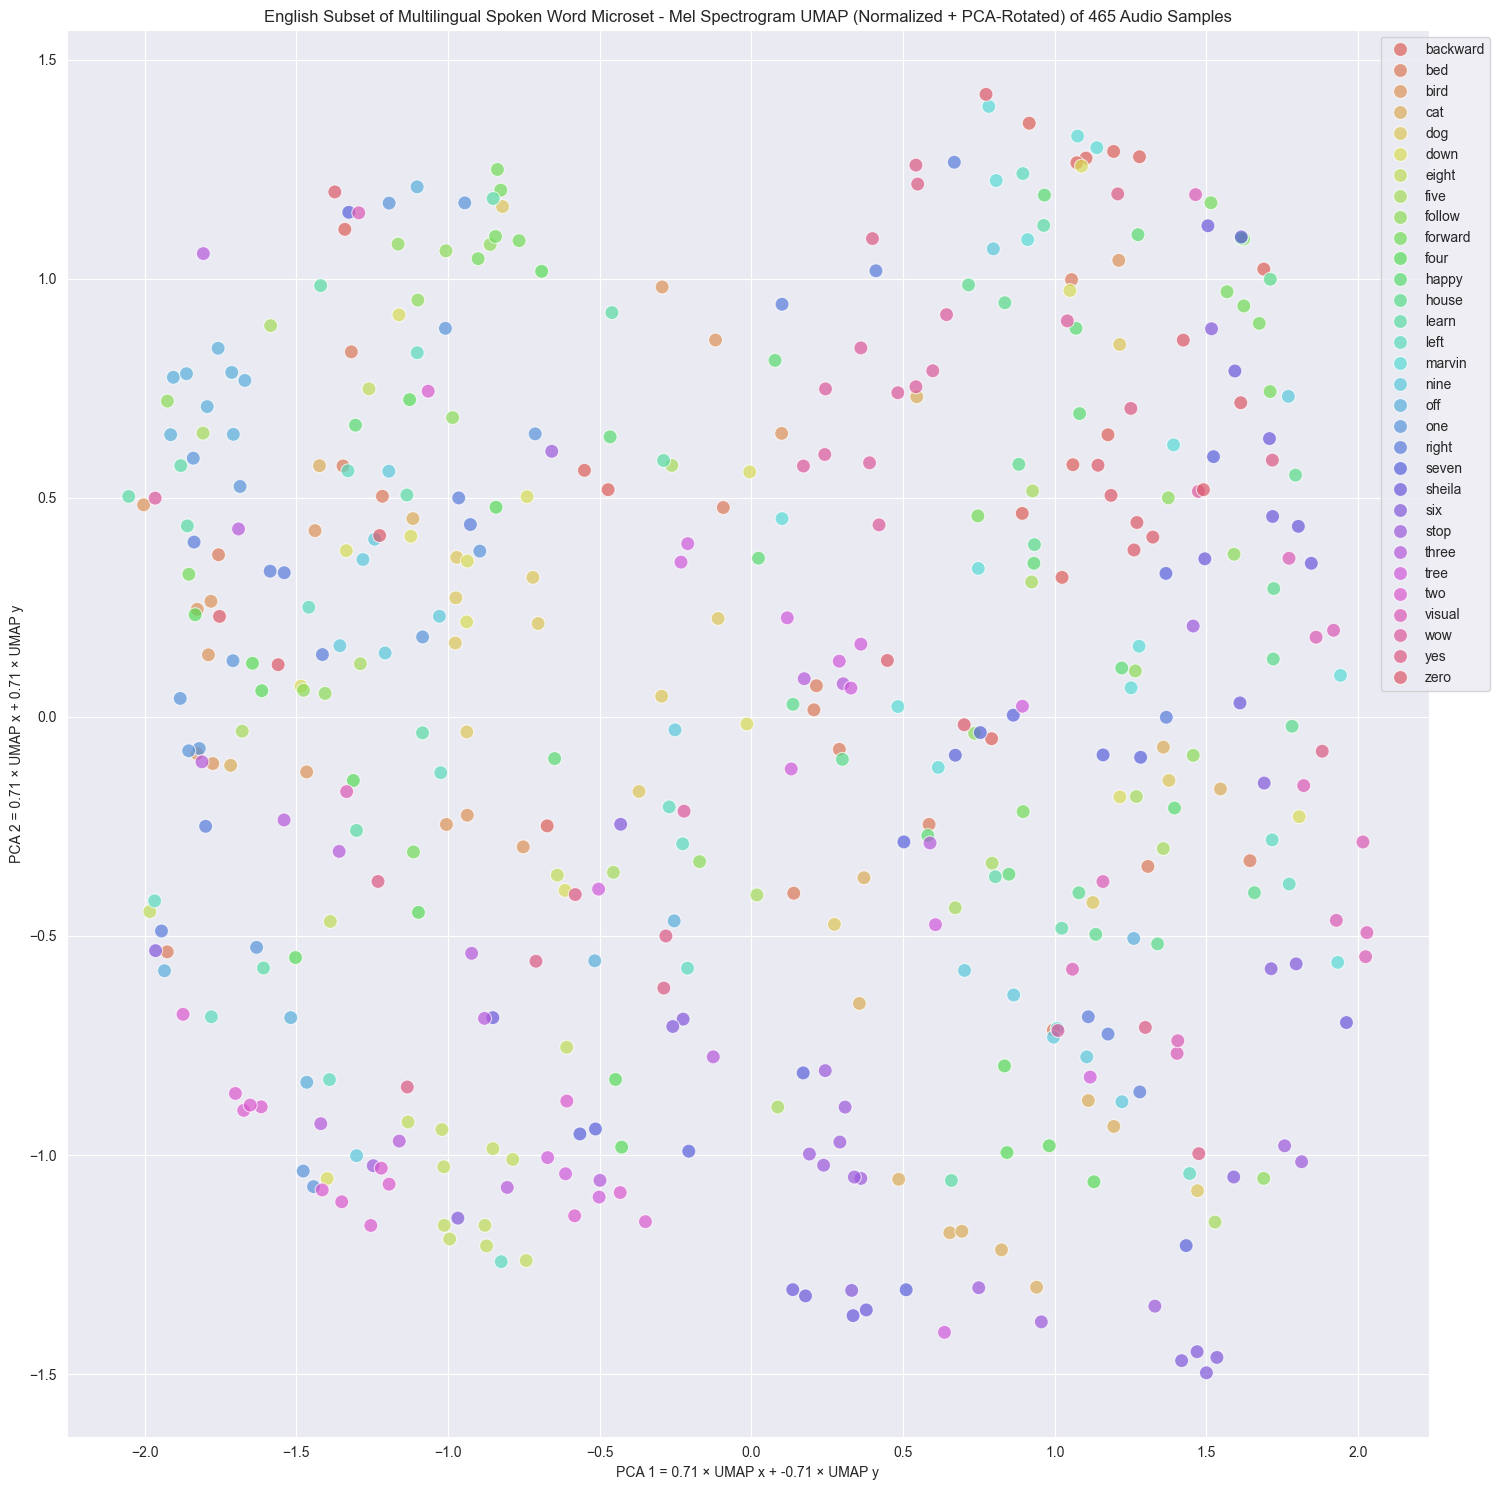

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize the UMAP embedding
scaler = StandardScaler()
normalized_embedding = scaler.fit_transform(embedding)

# Apply PCA to rotate the normalized UMAP embedding
pca = PCA(n_components=2)
rotated_embedding = pca.fit_transform(normalized_embedding)

# Get PCA component coefficients
pc1 = pca.components_[0]
pc2 = pca.components_[1]

# Format axis labels
x_label = f'PCA 1 = {pc1[0]:.2f} × UMAP x + {pc1[1]:.2f} × UMAP y'
y_label = f'PCA 2 = {pc2[0]:.2f} × UMAP x + {pc2[1]:.2f} × UMAP y'

# Create DataFrame for plotting
rotated_df = pd.DataFrame({
    'x': rotated_embedding[:, 0],
    'y': rotated_embedding[:, 1],
    'keyword': valid_labels
})

# Plot
plt.figure(figsize=(15, 15))
sns.scatterplot(
    x='x', y='y',
    hue='keyword',
    data=rotated_df,
    palette=sns.color_palette('hls', len(set(valid_labels))),
    s=100,
    alpha=0.7
)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(f"English Subset of Multilingual Spoken Word Microset - Mel Spectrogram UMAP (Normalized + PCA-Rotated) of {len(valid_labels)} Audio Samples")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


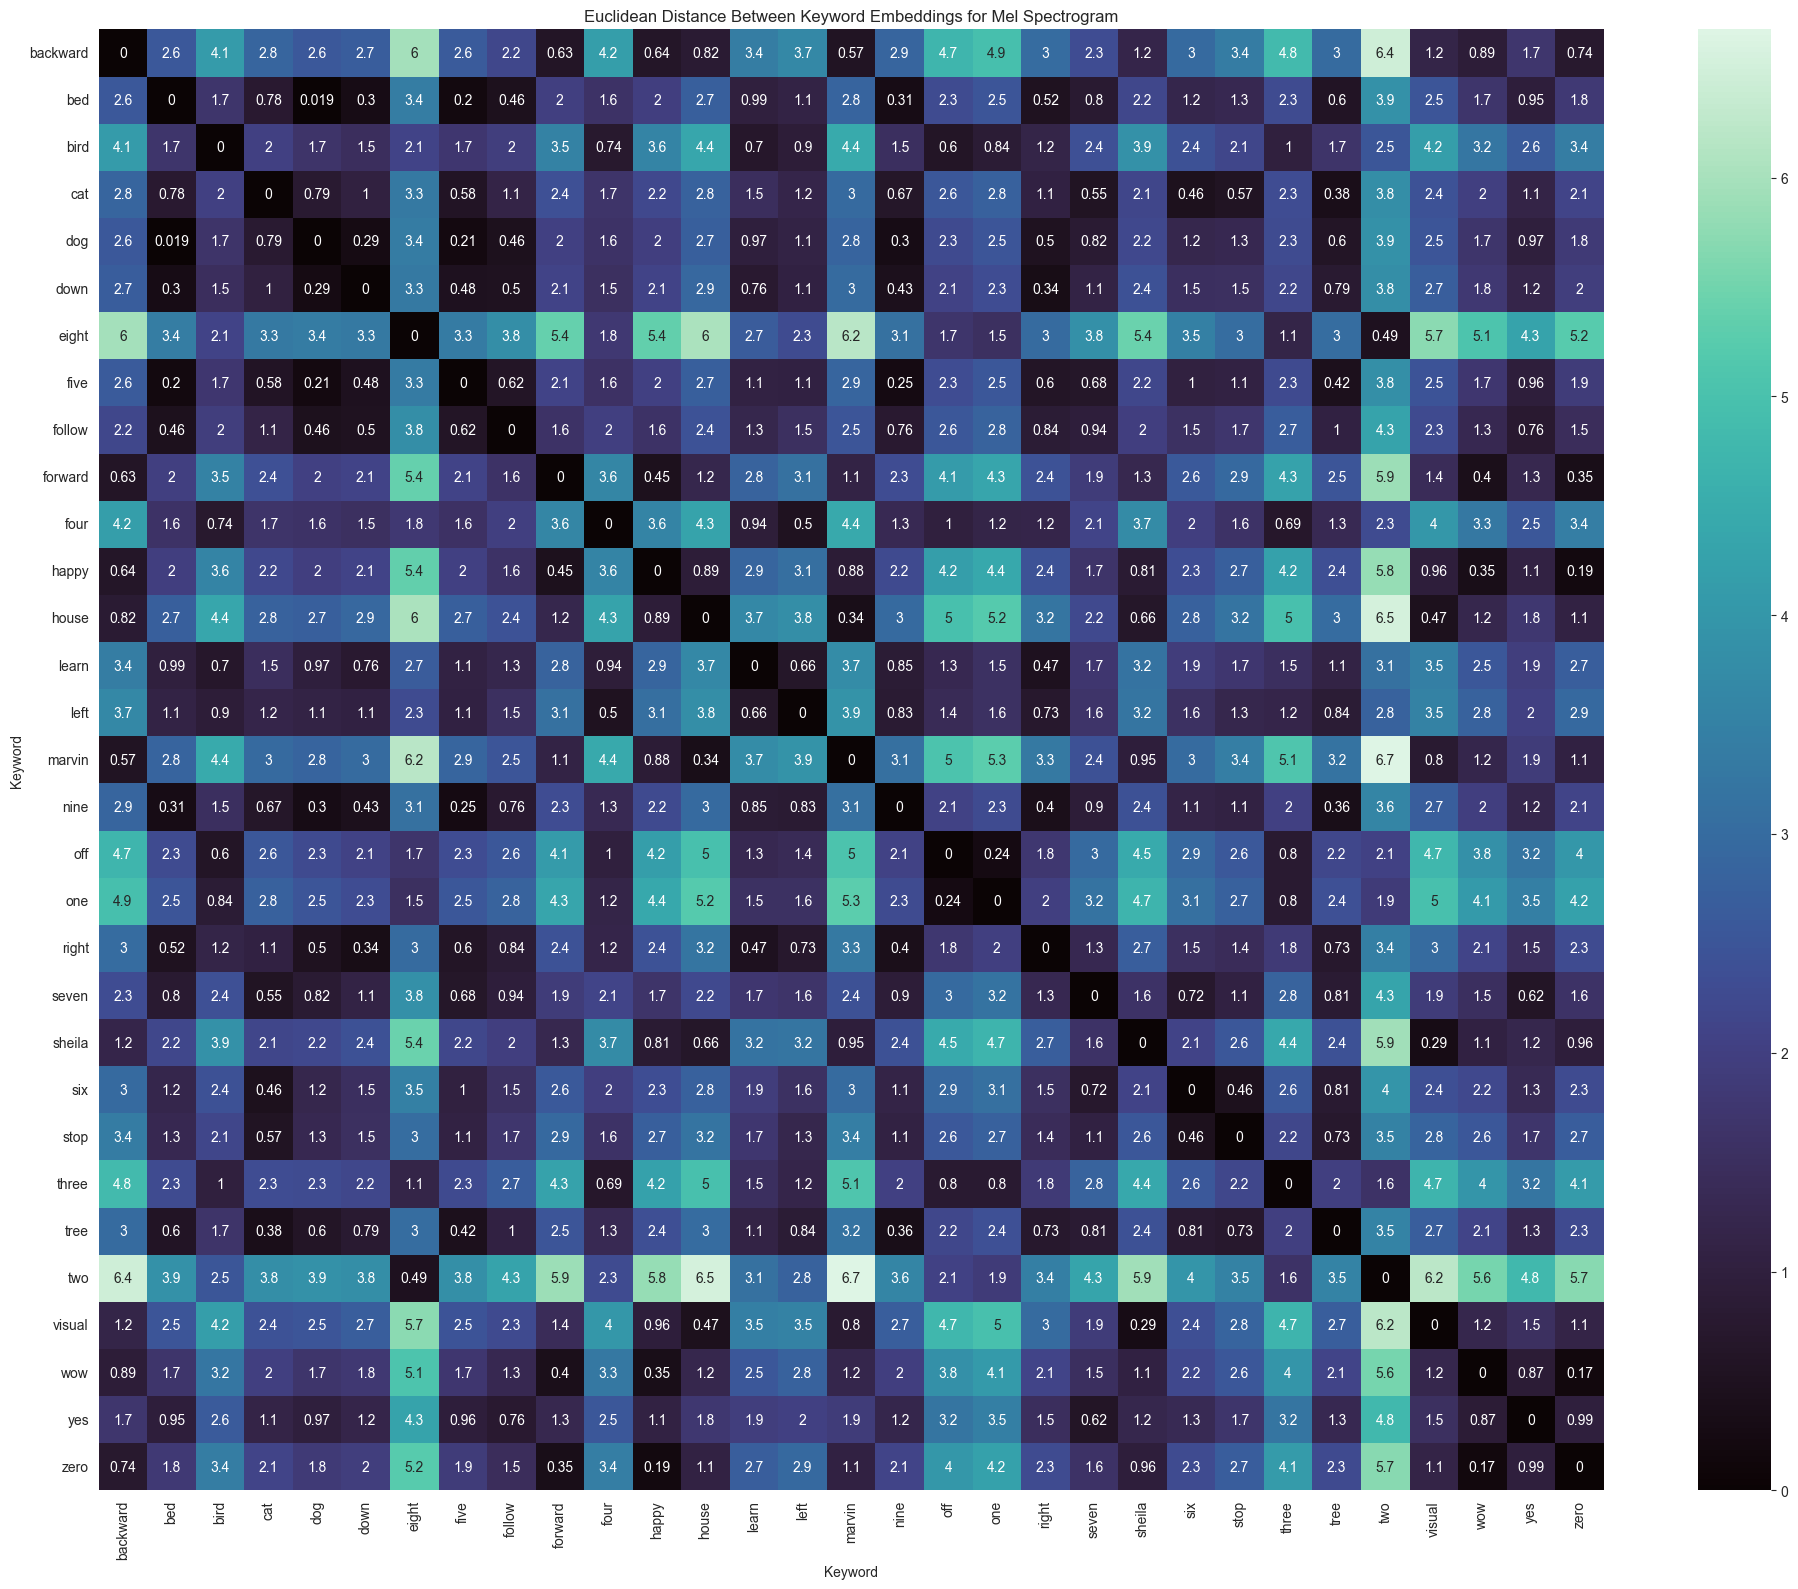

In [23]:
from scipy.spatial.distance import cdist

unique_labels = sorted(set(valid_labels))
label_to_vectors = {label: [] for label in unique_labels}
for label, vec in zip(valid_labels, embedding):
    label_to_vectors[label].append(vec)

label_means = {label: np.mean(vectors, axis=0) for label, vectors in label_to_vectors.items()}

# Calculate pairwise distances
mean_matrix = np.array([label_means[label] for label in unique_labels])
distance_matrix = cdist(mean_matrix, mean_matrix, metric='euclidean')

# Create heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(distance_matrix, xticklabels=unique_labels, yticklabels=unique_labels, cmap="mako", annot=True)
plt.title("Euclidean Distance Between Keyword Embeddings for Mel Spectrogram")
plt.xlabel("Keyword")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()

In [16]:
# Choose two keywords
target_keywords = ['nine', 'bed']  # Replace with actual keywords from your data

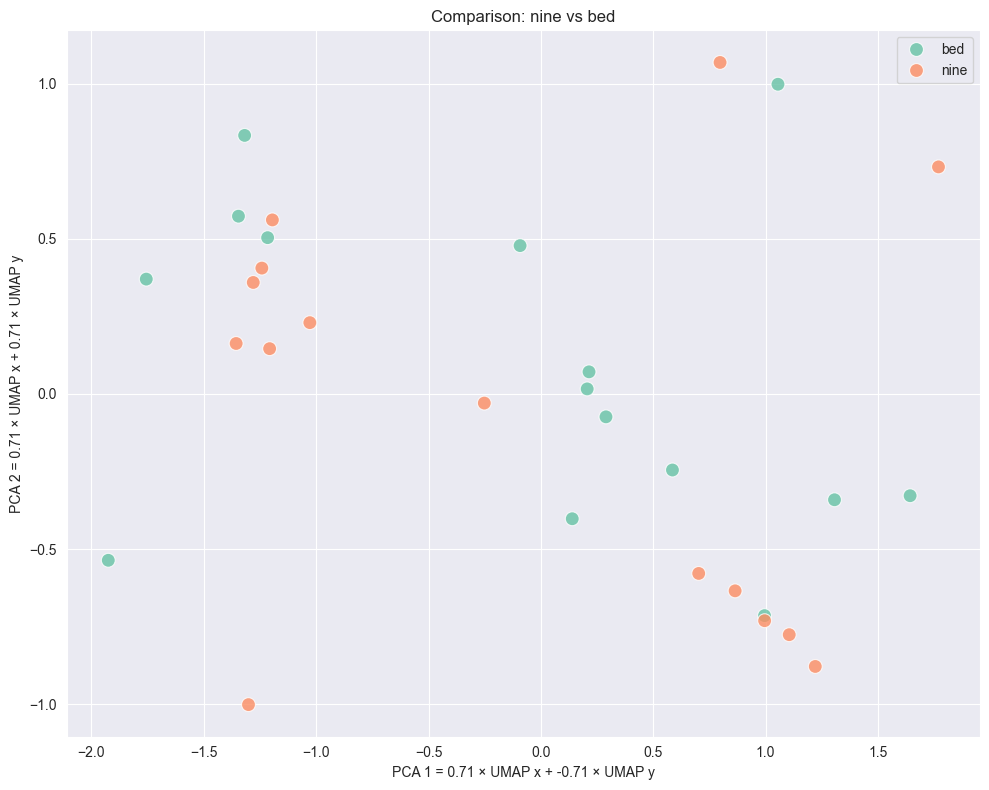

In [17]:
subset_df = rotated_df[rotated_df['keyword'].isin(target_keywords)]

# Plot with separate colors for each keyword
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='x', y='y', hue='keyword', data=subset_df, s=100, alpha=0.8,
    palette='Set2'
)
plt.title(f"Comparison: {target_keywords[0]} vs {target_keywords[1]}")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.tight_layout()
plt.show()

Silhouette Score: 0.5644


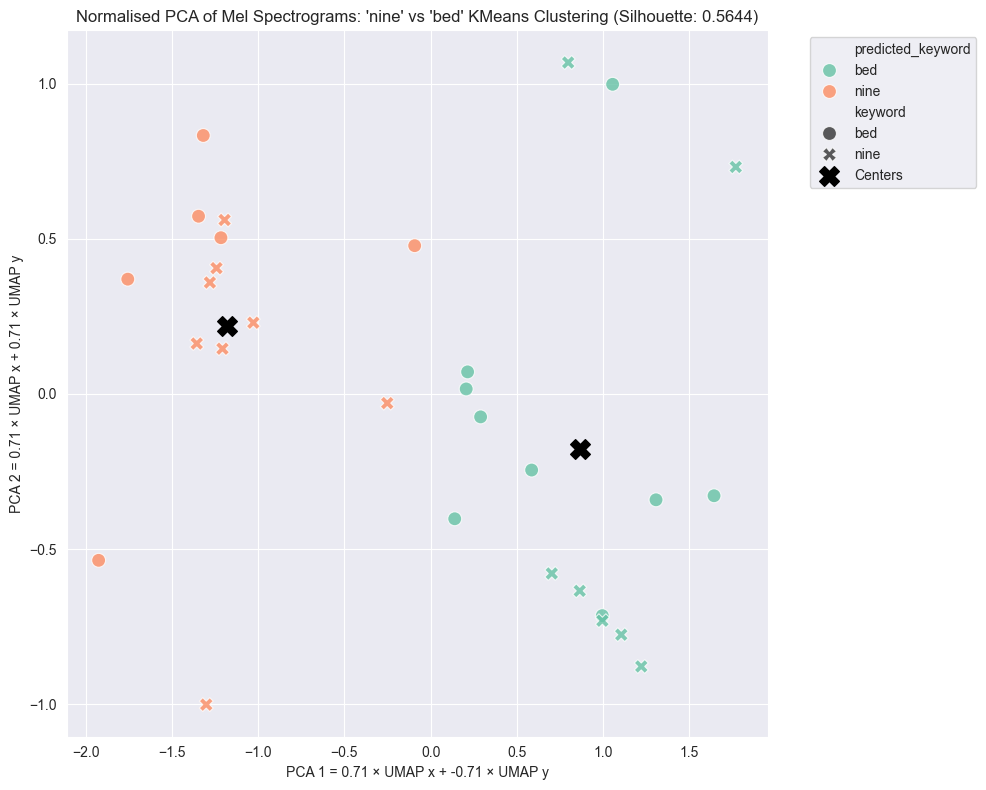

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter

# Filter dataframe for target keywords
subset_df = rotated_df[rotated_df['keyword'].isin(target_keywords)].copy()

# Prepare data for KMeans (only x, y coordinates)
X = subset_df[['x', 'y']].values

# Run KMeans with 2 clusters (since we have 2 words)
kmeans = KMeans(n_clusters=2, random_state=42)
subset_df['cluster'] = kmeans.fit_predict(X)
labels = kmeans.labels_

sil_score = silhouette_score(X, labels)
print(f"Silhouette Score: {sil_score:.4f}")

cluster_to_keyword = {}
for cluster_id in subset_df['cluster'].unique():
    keywords_in_cluster = subset_df[subset_df['cluster'] == cluster_id]['keyword']
    most_common_keyword = Counter(keywords_in_cluster).most_common(1)[0][0]
    cluster_to_keyword[cluster_id] = most_common_keyword

# Add predicted keyword column based on cluster assignment
subset_df['predicted_keyword'] = subset_df['cluster'].map(cluster_to_keyword)

# Now plot using predicted_keyword instead of cluster
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='x', y='y',
    hue='predicted_keyword',
    style='keyword',
    data=subset_df,
    palette='Set2',
    s=100,
    alpha=0.8
)

# Plot cluster centers as before
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, marker='X', label='Centers')

plt.title(f"Normalised PCA of Mel Spectrograms: '{target_keywords[0]}' vs '{target_keywords[1]}' KMeans Clustering (Silhouette: {sil_score:.4f})")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [19]:
results = []

# Loop over all unique pairs of keywords
for i in range(len(unique_labels)):
    for j in range(i + 1, len(unique_labels)):
        k1, k2 = unique_labels[i], unique_labels[j]

        # Filter for these two keywords
        subset_df = rotated_df[rotated_df['keyword'].isin([k1, k2])].copy()
        X = subset_df[['x', 'y']].values

        # Skip if not enough samples
        if len(X) < 4:
            continue

        # KMeans
        kmeans = KMeans(n_clusters=2, random_state=42)
        labels = kmeans.fit_predict(X)

        # Silhouette Score
        try:
            sil_score = silhouette_score(X, labels)
        except ValueError:
            sil_score = np.nan

        # Euclidean distance between cluster means in original UMAP space
        vec1 = np.mean([vec for lbl, vec in zip(valid_labels, embedding) if lbl == k1], axis=0)
        vec2 = np.mean([vec for lbl, vec in zip(valid_labels, embedding) if lbl == k2], axis=0)
        dist = np.linalg.norm(vec1 - vec2)

        results.append({
            'keyword_1': k1,
            'keyword_2': k2,
            'silhouette_score': sil_score,
            'euclidean_distance': dist
        })

# Create DataFrame
results_df = pd.DataFrame(results)

# Drop NaNs
results_df = results_df.dropna()

In [20]:
results_df

,keyword_1,keyword_2,silhouette_score,euclidean_distance
0,backward,bed,0.508756,2.562670
1,backward,bird,0.604636,4.105586
2,backward,cat,0.361794,2.848411
3,backward,dog,0.578332,2.575915
4,backward,down,0.607907,2.679566
...,...,...,...,...
460,visual,yes,0.574878,1.529388
461,visual,zero,0.690404,1.126743
462,wow,yes,0.538503,0.872789
463,wow,zero,0.665517,0.165723


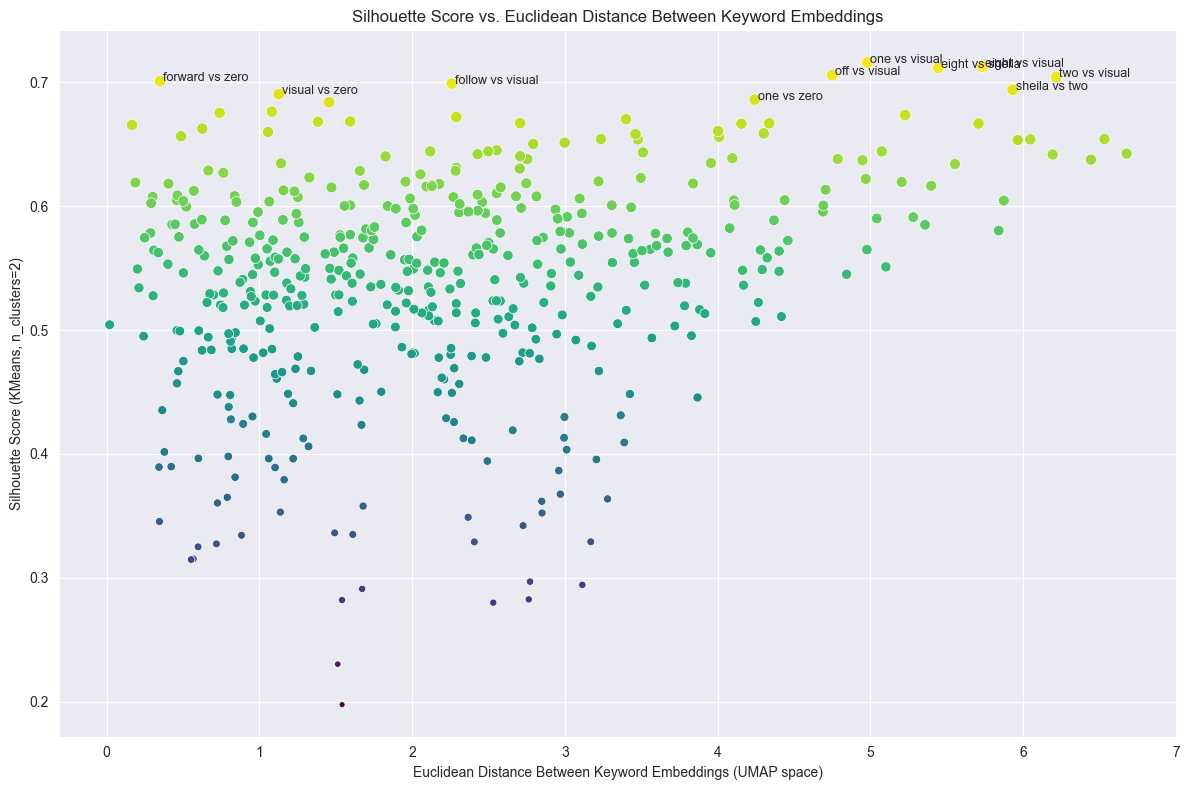

In [21]:
# Scatter plot of silhouette score vs. Euclidean distance
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='euclidean_distance',
    y='silhouette_score',
    hue='silhouette_score',
    size='silhouette_score',
    data=results_df,
    palette='viridis',
    legend=False
)

for _, row in results_df.nlargest(10, 'silhouette_score').iterrows():
    plt.text(row['euclidean_distance'] + 0.02, row['silhouette_score'],
             f"{row['keyword_1']} vs {row['keyword_2']}", fontsize=9)

plt.title("Silhouette Score vs. Euclidean Distance Between Keyword Embeddings")
plt.xlabel("Euclidean Distance Between Keyword Embeddings (UMAP space)")
plt.ylabel("Silhouette Score (KMeans, n_clusters=2)")
plt.tight_layout()
plt.show()


Pearson correlation (embedding distance vs silhouette): r = 0.436, p = 5.552e-23


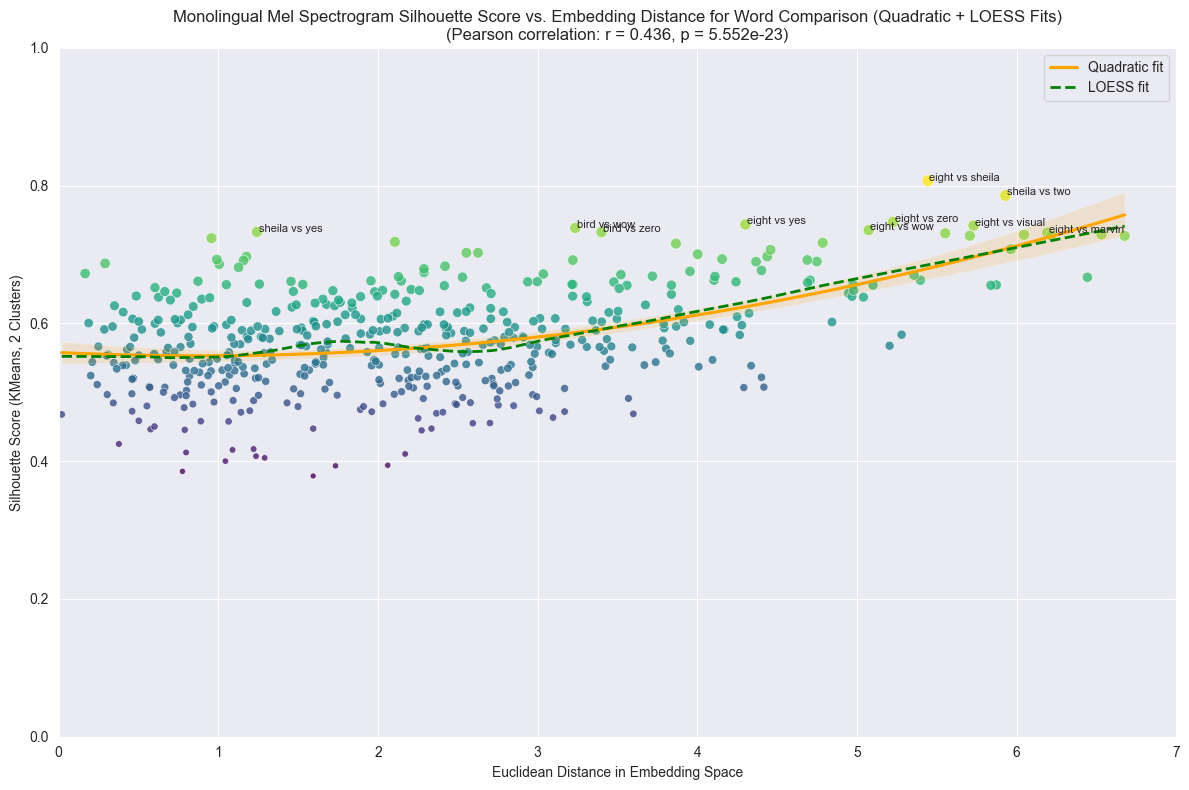

In [22]:
from scipy.stats import pearsonr
import itertools
import statsmodels.api as sm

unique_labels = sorted(set(valid_labels))
label_to_vectors = {label: [] for label in unique_labels}
for label, vec in zip(valid_labels, embedding):
    label_to_vectors[label].append(vec)

# Step 2: Precompute mean embeddings (embedding space) and UMAP means (rotated_df)
label_means_embed = {label: np.mean(vecs, axis=0) for label, vecs in label_to_vectors.items()}
label_means_umap = rotated_df.groupby("keyword")[["x", "y"]].mean().to_dict(orient="index")

# Step 3: Evaluate silhouette and distances
results = []
for kw1, kw2 in itertools.combinations(unique_labels, 2):
    vecs_kw1 = label_to_vectors[kw1]
    vecs_kw2 = label_to_vectors[kw2]
    vectors = np.array(vecs_kw1 + vecs_kw2)
    labels = [kw1] * len(vecs_kw1) + [kw2] * len(vecs_kw2)

    if len(set(labels)) < 2 or len(vectors) < 4:
        continue

    kmeans = KMeans(n_clusters=2, random_state=42)
    cluster_labels = kmeans.fit_predict(vectors)

    try:
        sil_score = silhouette_score(vectors, cluster_labels)
    except ValueError:
        sil_score = np.nan

    # Euclidean distance in full embedding space
    embed_dist = np.linalg.norm(label_means_embed[kw1] - label_means_embed[kw2])

    # Euclidean distance in UMAP space
    if kw1 in label_means_umap and kw2 in label_means_umap:
        umap_vec1 = np.array([label_means_umap[kw1]["x"], label_means_umap[kw1]["y"]])
        umap_vec2 = np.array([label_means_umap[kw2]["x"], label_means_umap[kw2]["y"]])
        umap_dist = np.linalg.norm(umap_vec1 - umap_vec2)
    else:
        umap_dist = np.nan

    results.append({
        'keyword_1': kw1,
        'keyword_2': kw2,
        'silhouette_score': sil_score,
        'embedding_distance': embed_dist,
        'umap_distance': umap_dist
    })

# Step 4: Create DataFrame and clean
results_df = pd.DataFrame(results)
results_df.dropna(inplace=True)

# Step 5: Correlation
r, p = pearsonr(results_df["embedding_distance"], results_df["silhouette_score"])
print(f"Pearson correlation (embedding distance vs silhouette): r = {r:.3f}, p = {p:.3e}")

plt.figure(figsize=(12, 8))

# Scatter plot (unchanged)
sns.scatterplot(
    data=results_df,
    x="embedding_distance",
    y="silhouette_score",
    hue="silhouette_score",
    size="silhouette_score",
    palette="viridis",
    legend=False,
    alpha=0.8
)

# Quadratic fit (unchanged)
sns.regplot(
    data=results_df,
    x="embedding_distance",
    y="silhouette_score",
    scatter=False,
    color="orange",
    order=2,
    ci=95,
    label='Quadratic fit'
)

# --- NEW: Add LOESS trend line ---
# Using statsmodels (more customizable)
lowess = sm.nonparametric.lowess(
    results_df["silhouette_score"],
    results_df["embedding_distance"],
    frac=0.3  # Fraction of data to use for local regression (adjust as needed)
)
plt.plot(
    lowess[:, 0],
    lowess[:, 1],
    color="green",
    linewidth=2,
    linestyle="--",
    label="LOESS fit"
)

plt.xlim(0, 7)      # Force x-axis range (0 to 7)
plt.ylim(0, 1)      # Force y-axis range (0 to 1)
top_n = 10
# Annotate top pairs (unchanged)
for _, row in results_df.nlargest(top_n, "silhouette_score").iterrows():
    plt.text(
        row["embedding_distance"] + 0.01,
        row["silhouette_score"],
        f"{row['keyword_1']} vs {row['keyword_2']}",
        fontsize=8
    )


plt.title(f"Monolingual Mel Spectrogram Silhouette Score vs. Embedding Distance for Word Comparison (Quadratic + LOESS Fits)"
          f"\n(Pearson correlation: r = {r:.3f}, p = {p:.3e})")
plt.xlabel("Euclidean Distance in Embedding Space")
plt.ylabel("Silhouette Score (KMeans, 2 Clusters)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()